In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np # линейная алгебра
import pandas as pd # обработка данных, ввод-вывод CSV-файла (например, pd.read_csv)

# Библиотеки визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Библиотеки машинного обучения
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2,f_classif
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

import pickle
import string

# Библиотеки для обработки текста
import nltk
from nltk.stem import PorterStemmer
import os

# Загружаем набор данных

In [2]:
df=pd.read_csv('/Users/LENOVO/DESKTOP/jupyter/Suicide_corpus.csv')
df.head()

,text,class
0,"Когда-то я был добрым романтиком, который стре...",suicide
1,Здраствуйте! Я каждый день просыпаюсь с мыслью...,suicide
2,У меня проблемы с девушкой. Каждую ссору я не ...,suicide
3,"Вся моя жизнь это один сплошной ад, в котором ...",suicide
4,Я хочу уснуть и не проснуться.каждый день одно...,suicide


In [3]:
df.shape

(64039, 2)

In [4]:
df['class'].value_counts()

non-suicide    32021
suicide        32018
Name: class, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64039 entries, 0 to 64038
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    64039 non-null  object
 1   class   64039 non-null  object
dtypes: object(2)
memory usage: 1000.7+ KB


In [6]:
df.duplicated().sum()

0

# Визуализация данных

non-suicide    32021
suicide        32018
Name: class, dtype: int64


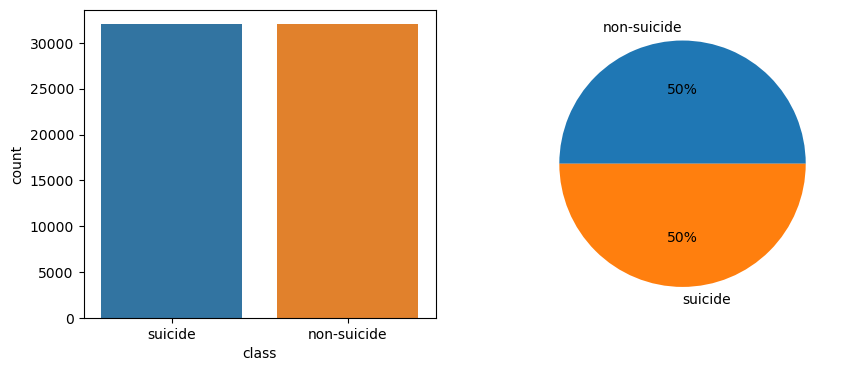

In [7]:
classCnt = df['class'].value_counts()
print(classCnt)

plt.figure(figsize=((10,4)))

plt.subplot(1,2,1)
sns.countplot(df,x='class')

plt.subplot(1,2,2)
plt.pie(classCnt,labels = classCnt.index,autopct='%.0f%%')

plt.show()

# Предварительная обработка данных

In [8]:
df['text']= df['text'].str.lower()

## Удаление стоп слов и знаки препинания

In [9]:
df['text'] = df['text'].str.replace(r'[^\w\s]+', '',regex = True)

In [10]:
from nltk.corpus import stopwords
stop_words = nltk.corpus.stopwords.words('russian')
stop_words = set(stopwords.words("russian"))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# Токенизация

In [11]:
df['text'] = df['text'].apply(lambda x:nltk.word_tokenize(x))

## Стемматизация

In [12]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [13]:
df['text'] = df['text'].apply(lambda x: [morph.parse(word)[0].normal_form for word in x])
df['text'] = df['text'].apply(lambda x: ' '.join(x))
df.head()

,text,class
0,когдато добрый романтик который стремиться пом...,suicide
1,здраствовать каждый день просыпаться мысль жит...,suicide
2,проблема девушка каждый ссора мочь перенести о...,suicide
3,весь жизнь это сплошной ад который горе постоя...,suicide
4,хотеть уснуть проснутьсякаждый день один какой...,suicide


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64039 entries, 0 to 64038
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    64039 non-null  object
 1   class   64039 non-null  object
dtypes: object(2)
memory usage: 1000.7+ KB


In [15]:
ind = df[df['text'].isnull()].index

In [16]:
df.iloc[ind]

,text,class


In [17]:
df.dropna(inplace=True)

## TF-IDF векторизатор

In [18]:
x,y = df['text'],df['class']

In [19]:
vectorizer = TfidfVectorizer(min_df=50,max_features=5000)
x =  vectorizer.fit_transform(x).toarray()

In [20]:
# Сохранение модели
with open('tfidf.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)  

## Разделение данных

In [56]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=7)

In [57]:
X_train.shape,X_test.shape

((51231, 5000), (12808, 5000))

# Наивный Байесовский классификатор

In [58]:
nb = GaussianNB()
nb2 = BernoulliNB()
nb3 = MultinomialNB()
VotingClassifiers = VotingClassifier(estimators=[('GaussianNB', nb),('BernoulliNB',nb2), ('MultinomialNB', nb3)], voting = 'soft')
VotingClassifiers.fit(X_train, y_train)
print('Training score:',VotingClassifiers.score(X_train, y_train))
print('Testing score:',VotingClassifiers.score(X_test,y_test))

Training score: 0.986902461400324
Testing score: 0.986102435977514


              precision    recall  f1-score   support

 non-suicide       1.00      0.98      0.99      6329
     suicide       0.98      1.00      0.99      6479

    accuracy                           0.99     12808
   macro avg       0.99      0.99      0.99     12808
weighted avg       0.99      0.99      0.99     12808



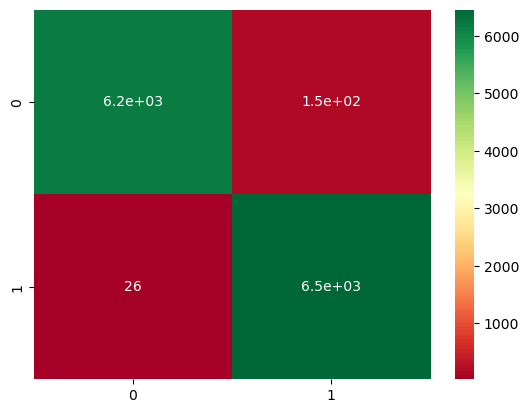

In [59]:
y_act=y_test
y_pred=VotingClassifiers.predict(X_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='RdYlGn')
print(classification_report(y_act,y_pred))

# Random Forest

In [40]:
classifiers = RandomizedSearchCV(RandomForestClassifier(),{'n_estimators':[4,5],'criterion':['entropy'],
                                                      'max_depth':range(1,4),'min_samples_split':range(2,5)},random_state=10)
classifiers.fit(X_train, y_train)
print('Training score:',classifiers.score(X_train, y_train))
print('Testing score:',classifiers.score(X_test,y_test))
print(classifiers.best_estimator_)

Training score: 0.736311998594601
Testing score: 0.7352435977514054
RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=4)


              precision    recall  f1-score   support

 non-suicide       0.98      0.56      0.72       485
     suicide       0.71      0.99      0.82       515

    accuracy                           0.78      1000
   macro avg       0.84      0.78      0.77      1000
weighted avg       0.84      0.78      0.77      1000



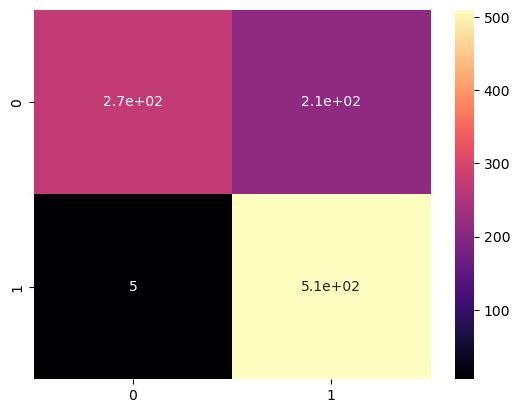

In [20]:
y_act=y_test
y_pred=classifiers.predict(X_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='magma')
print(classification_report(y_act,y_pred))

# Decision Tree (Шешім ағашы)

In [32]:
model2 = DecisionTreeClassifier(criterion='gini',splitter='random',min_samples_leaf=70,max_depth=4,random_state=7)
model2.fit(X_train, y_train)
print(model2.score(X_train, y_train))
print(model2.score(X_test,y_test))

0.806952821533837
0.8023891317926296


              precision    recall  f1-score   support

 non-suicide       0.73      0.95      0.83      6329
     suicide       0.94      0.65      0.77      6479

    accuracy                           0.80     12808
   macro avg       0.83      0.80      0.80     12808
weighted avg       0.83      0.80      0.80     12808



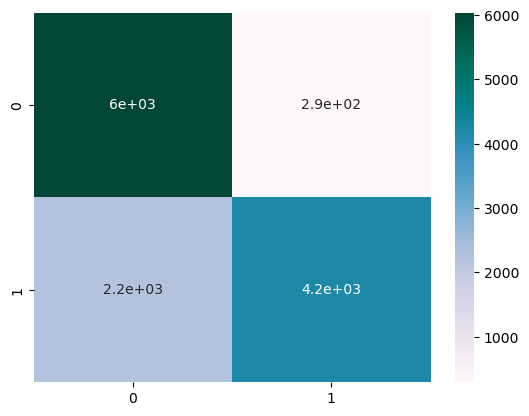

In [33]:
y_act=y_test
y_pred=model2.predict(X_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='PuBuGn')
print(classification_report(y_act,y_pred))

In [21]:
model = XGBClassifier( eval_metric='map',max_depth=200,n_estimators=70,learning_rate=1.99)
model.fit(X_train,y_train.replace({"non-suicide":0,'suicide':1}))
print('Training score:',model.score(X_train,y_train.replace({"non-suicide":0,'suicide':1})))
print('Testing score:',model.score(X_test,y_test.replace({"non-suicide":0,'suicide':1})))

Training score: 0.7305
Testing score: 0.703


              precision    recall  f1-score   support

           0       0.68      0.74      0.71       485
           1       0.73      0.66      0.70       515

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.70      1000
weighted avg       0.71      0.70      0.70      1000



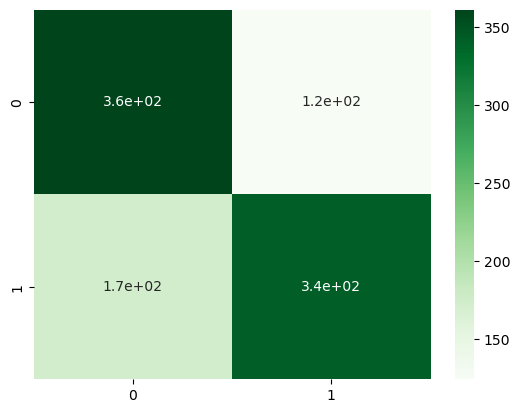

In [22]:
#матрица путаницы и отчет о классификации
y_act = y_test.replace({"non-suicide":0,'suicide':1})
y_pred = model.predict(X_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='Greens')
print(classification_report(y_act,y_pred))

In [ ]:
model = RandomizedSearchCV(KNeighborsClassifier(),{'n_neighbors':[8],'metric':['manhattan','minkowski','cosine','tanimoto'],
                                                   'p':[1,2]},random_state=0,n_jobs=-1)
model.fit(X_train, y_train)
print('Training score:',model.score(X_train, y_train))
print('Testing score:',model.score(X_test,y_test))
print(model.best_estimator_)

In [ ]:
y_act = y_test
y_pred = model.predict(X_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='autumn')
print(classification_report(y_act,y_pred))

# Вывод
### Исходя из вышеизложенного, мы можем сказать, что из всех моделей наивный Байес (классификатор голосования) является наиболее подходящей моделью для набора данных.
### Оценка за обучение: 0.9846074910210364
### Результат тестирования: 0.9834998958983968
### Точность : 99%

# Анализатор текста с моделью Naive Bayes

In [60]:
with open('best_model.pkl', 'wb') as f:
    pickle.dump(VotingClassifiers, f)  

In [61]:
def preprocess(inp):
    inp = inp.lower() #преобразовать в нижний регистр
    inp = inp.replace(r'[^\w\s]+', '') #убрать знаки препинания
    inp = [word for word in inp.split() if word not in (stop_words)] #токенизация предложение
    inp = ' '.join([morph.parse(word)[0].normal_form for word in inp]) #стемминг
    inputToModel = vectorizer.transform([inp]).toarray() #преобразовать в векторную форму
    return inputToModel

In [62]:
def app(input_text):
    # Определите текстовое поле ввода
    print('Input : ',input_text) #принимать вводимые данные от пользователя
    processed_array = preprocess(input_text) #предварительная обработка текста
    predict = VotingClassifiers.predict(processed_array) #Прогнозирование модели
    print('Output : ', predict[0])

In [63]:
app('Я устал от жизни, хочу умереть')

Input :  Я устал от жизни, хочу умереть
Output :  suicide


In [32]:
app('Свежие новости Алматы и главные события в городе на сегодня')

Input :  Свежие новости Алматы и главные события в городе на сегодня
Output :  non-suicide


In [47]:
app('Я прыгаю с моста Сегодня вечером')

Input :  Я прыгаю с моста Сегодня вечером
Output :  suicide


In [34]:
app('Я сегодня провалил все экзамены и не вижу смысла дальше жить')

Input :  Я сегодня провалил все экзамены и не вижу смысла дальше жить
Output :  suicide


In [35]:
app('Последние новости Алматы рассказывают о важных событиях, которые произошли на территории города и страны')

Input :  Последние новости Алматы рассказывают о важных событиях, которые произошли на территории города и страны
Output :  non-suicide


In [36]:
app('не хочу жить')

Input :  не хочу жить
Output :  suicide


In [37]:
app('Я прожил уже 90 лет и с каждым днем чувствую что мой конец очень близко')

Input :  Я прожил уже 90 лет и с каждым днем чувствую что мой конец очень близко
Output :  suicide


In [41]:
app('И может, кому-то покажется это глупым, но мне реально тяжело, и чувство безысходности толкает на суицид')

Input :  И может, кому-то покажется это глупым, но мне реально тяжело, и чувство безысходности толкает на суицид
Output :  suicide


In [44]:
app('Не хочу жить, все разговоры с девушками сводятся к обмену парами фраз и постоянным неловким молчанием, сегодня мой единственный друг женился, я веду себя на его свадьбе как побитый пес с опущенной головой ,знакомый переспал с девушкой в которую я был тайно влюблен, хочется все рвать и метать в клочья, хотя с его стороны вины никакой нету, это я затупок ,я просто не понимаю себя - постоянно сижу молчу, сам я не трус в плане, например прыжков с парашюта, но никак не могу найти в себе сил решить вроде бы обыденные вопросы для стандартного такого парня')

Input :  Не хочу жить, все разговоры с девушками сводятся к обмену парами фраз и постоянным неловким молчанием, сегодня мой единственный друг женился, я веду себя на его свадьбе как побитый пес с опущенной головой ,знакомый переспал с девушкой в которую я был тайно влюблен, хочется все рвать и метать в клочья, хотя с его стороны вины никакой нету, это я затупок ,я просто не понимаю себя - постоянно сижу молчу, сам я не трус в плане, например прыжков с парашюта, но никак не могу найти в себе сил решить вроде бы обыденные вопросы для стандартного такого парня
Output :  suicide


In [51]:
app('Я сегодня вечером собираюсь спрыгнуть с моста')

Input :  Я сегодня вечером собираюсь спрыгнуть с моста
Output :  suicide
